# **Head Pose Estimation**

TABLE OF CONTENTS:

1.   Reading and Exploring The Dataset
2.   Feature Engineering
3.   Data Preprocessing
4.   Train The machine learning model and Evaluation
5.   Testing the Model on Training Images and Vedios

### Problem Statement:
The goal is to estimate the direction in which the person is looking.
This can be done using the orientation of the head.
The orientation of the head can be defined in terms of pitch, roll, and yaw movements describing the three degrees of freedom of a human head.

## Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

### Required Libraries

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io
from math import cos, sin
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Reading and Exploring The Dataset

In [4]:
import sys
sys.path.append('/content/gdrive/content/AFLW2000')

In [5]:
import zipfile
path = '/content/gdrive/MyDrive/ML 1 dataset/AFLW2000-3D.zip'
zip_obj = zipfile.ZipFile(file=path,mode='r')
zip_obj.extractall('./')
zip_obj.close()

Number of images found: 2000
Image shape:  (450, 450, 3)


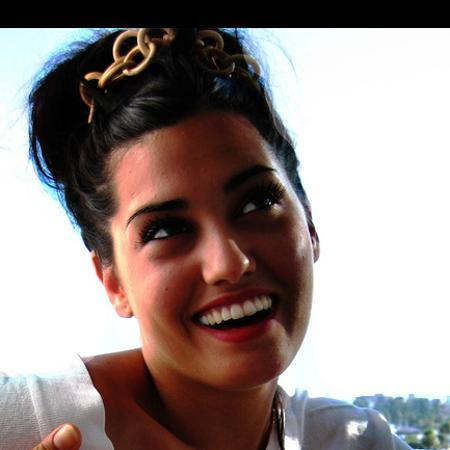

In [6]:
random_image = 601

image_paths = sorted(glob.glob('./AFLW2000/*.jpg'))
num_images = len(image_paths)
print(f"Number of images found: {num_images}")
img = cv2.imread(image_paths[random_image])

print('Image shape: ', img.shape)

cv2_imshow(img)

In [7]:
#Extracting pitch, yaw, and roll
img_info_paths = sorted(glob.glob('./AFLW2000/*.mat'))
mat = scipy.io.loadmat(img_info_paths[random_image])
pose_params = mat['Pose_Para'][0][:3] 

print(f"The pitch, yaw and roll for this pic : {pose_params}")



The pitch, yaw and roll for this pic : [ 0.06300466 -0.11383434 -0.2985448 ]


## Using mediapipe's mesh grid to find the landmarks of the face

Nose position: (234.37544703483582, 270.0045704841614)


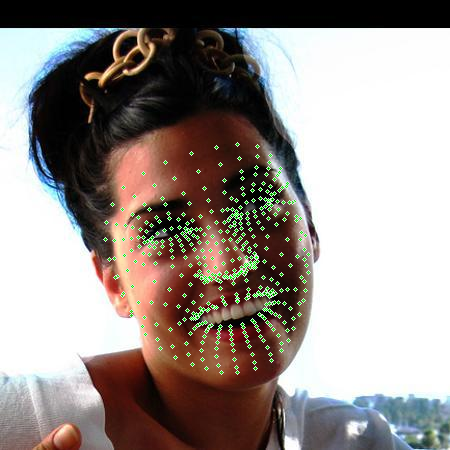

In [8]:
# Initialize FaceMesh object and DrawingSpec
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

drawing_specs = mp.solutions.drawing_utils.DrawingSpec(thickness=1, circle_radius=1, color=(0, 255, 0))

# Detect landmarks on input image
result = face_mesh.process(img)

# Create copy of input image and extract dimensions
img_h, img_w, img_c = img.shape
annot_img = img.copy()

# Draw landmarks on faces in image and extract nose position
if result.multi_face_landmarks is not None:
    for face_landmarks in result.multi_face_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            image=annot_img,
            landmark_list=face_landmarks,
            landmark_drawing_spec=drawing_specs)
        for idx, lm in enumerate(result.multi_face_landmarks[0].landmark):
            if idx == 1:
                nose_x = lm.x * img_w
                nose_y = lm.y * img_h

# Print nose position and display annotated image
print(f"Nose position: ({nose_x}, {nose_y})")
cv2_imshow(annot_img)

In [9]:
def draw_axes(image, pitch=None, yaw=None, roll=None, tx=None, ty=None, size=50):
    """
    Draw a set of 3D axes on an image to represent the orientation of an object.

    :param image: the input image
    :param pitch: the pitch angle in radians
    :param yaw: the yaw angle in radians
    :param roll: the roll angle in radians
    :param tx: the translation along the x-axis
    :param ty: the translation along the y-axis
    :param size: the size of the axes in pixels (default is 50)
    :return: a new image with the axes drawn on it
    """
    if yaw == None :
      return image
    # Invert the yaw angle to convert from left-handed to right-handed coordinates
    yaw = -yaw

    # Compute the rotation matrix from the pitch, yaw, and roll angles
    rotation_matrix = cv2.Rodrigues(np.array([pitch, yaw, roll]))[0].astype(np.float64)

    # Define the 3D axes in object space
    axes_points = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]
    ], dtype=np.float64)

    # Apply the rotation matrix to the axes to bring them to image space
    axes_points = rotation_matrix @ axes_points

    # Scale the axes by the given size and apply the translation
    axes_points = (axes_points[:2, :] * size).astype(int)
    axes_points[0, :] = axes_points[0, :] + tx
    axes_points[1, :] = axes_points[1, :] + ty

    # Draw each axis as a line and label it with a letter
    new_image = image.copy()
    cv2.line(new_image, tuple(axes_points[:, 3]), tuple(axes_points[:, 0]), (255, 0, 0), 3)
    cv2.putText(new_image, 'x', tuple(axes_points[:, 0]), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 0), 1)

    cv2.line(new_image, tuple(axes_points[:, 3]), tuple(axes_points[:, 1]), (0, 255, 0), 3)
    cv2.putText(new_image, 'y', tuple(axes_points[:, 1]), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 0), 1)

    cv2.line(new_image, tuple(axes_points[:, 3]), tuple(axes_points[:, 2]), (0, 0, 255), 3)
    cv2.putText(new_image, 'z', tuple(axes_points[:, 2]), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 255), 1)

    return new_image
  

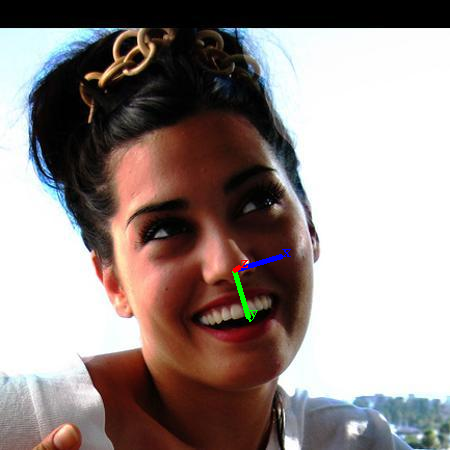

In [10]:
pitch, yaw, roll = mat['Pose_Para'][0][:3]
new_img = draw_axes(img, pitch, yaw, roll, nose_x, nose_y)

cv2_imshow(new_img)

## Feature Extraction
As most of the points in the face mesh are close to each other and don't offer new information.
I will use some of the main points of the face mesh grid as the features, and use them to estimate the value of the rotation angles: pitch, yaw, and roll.

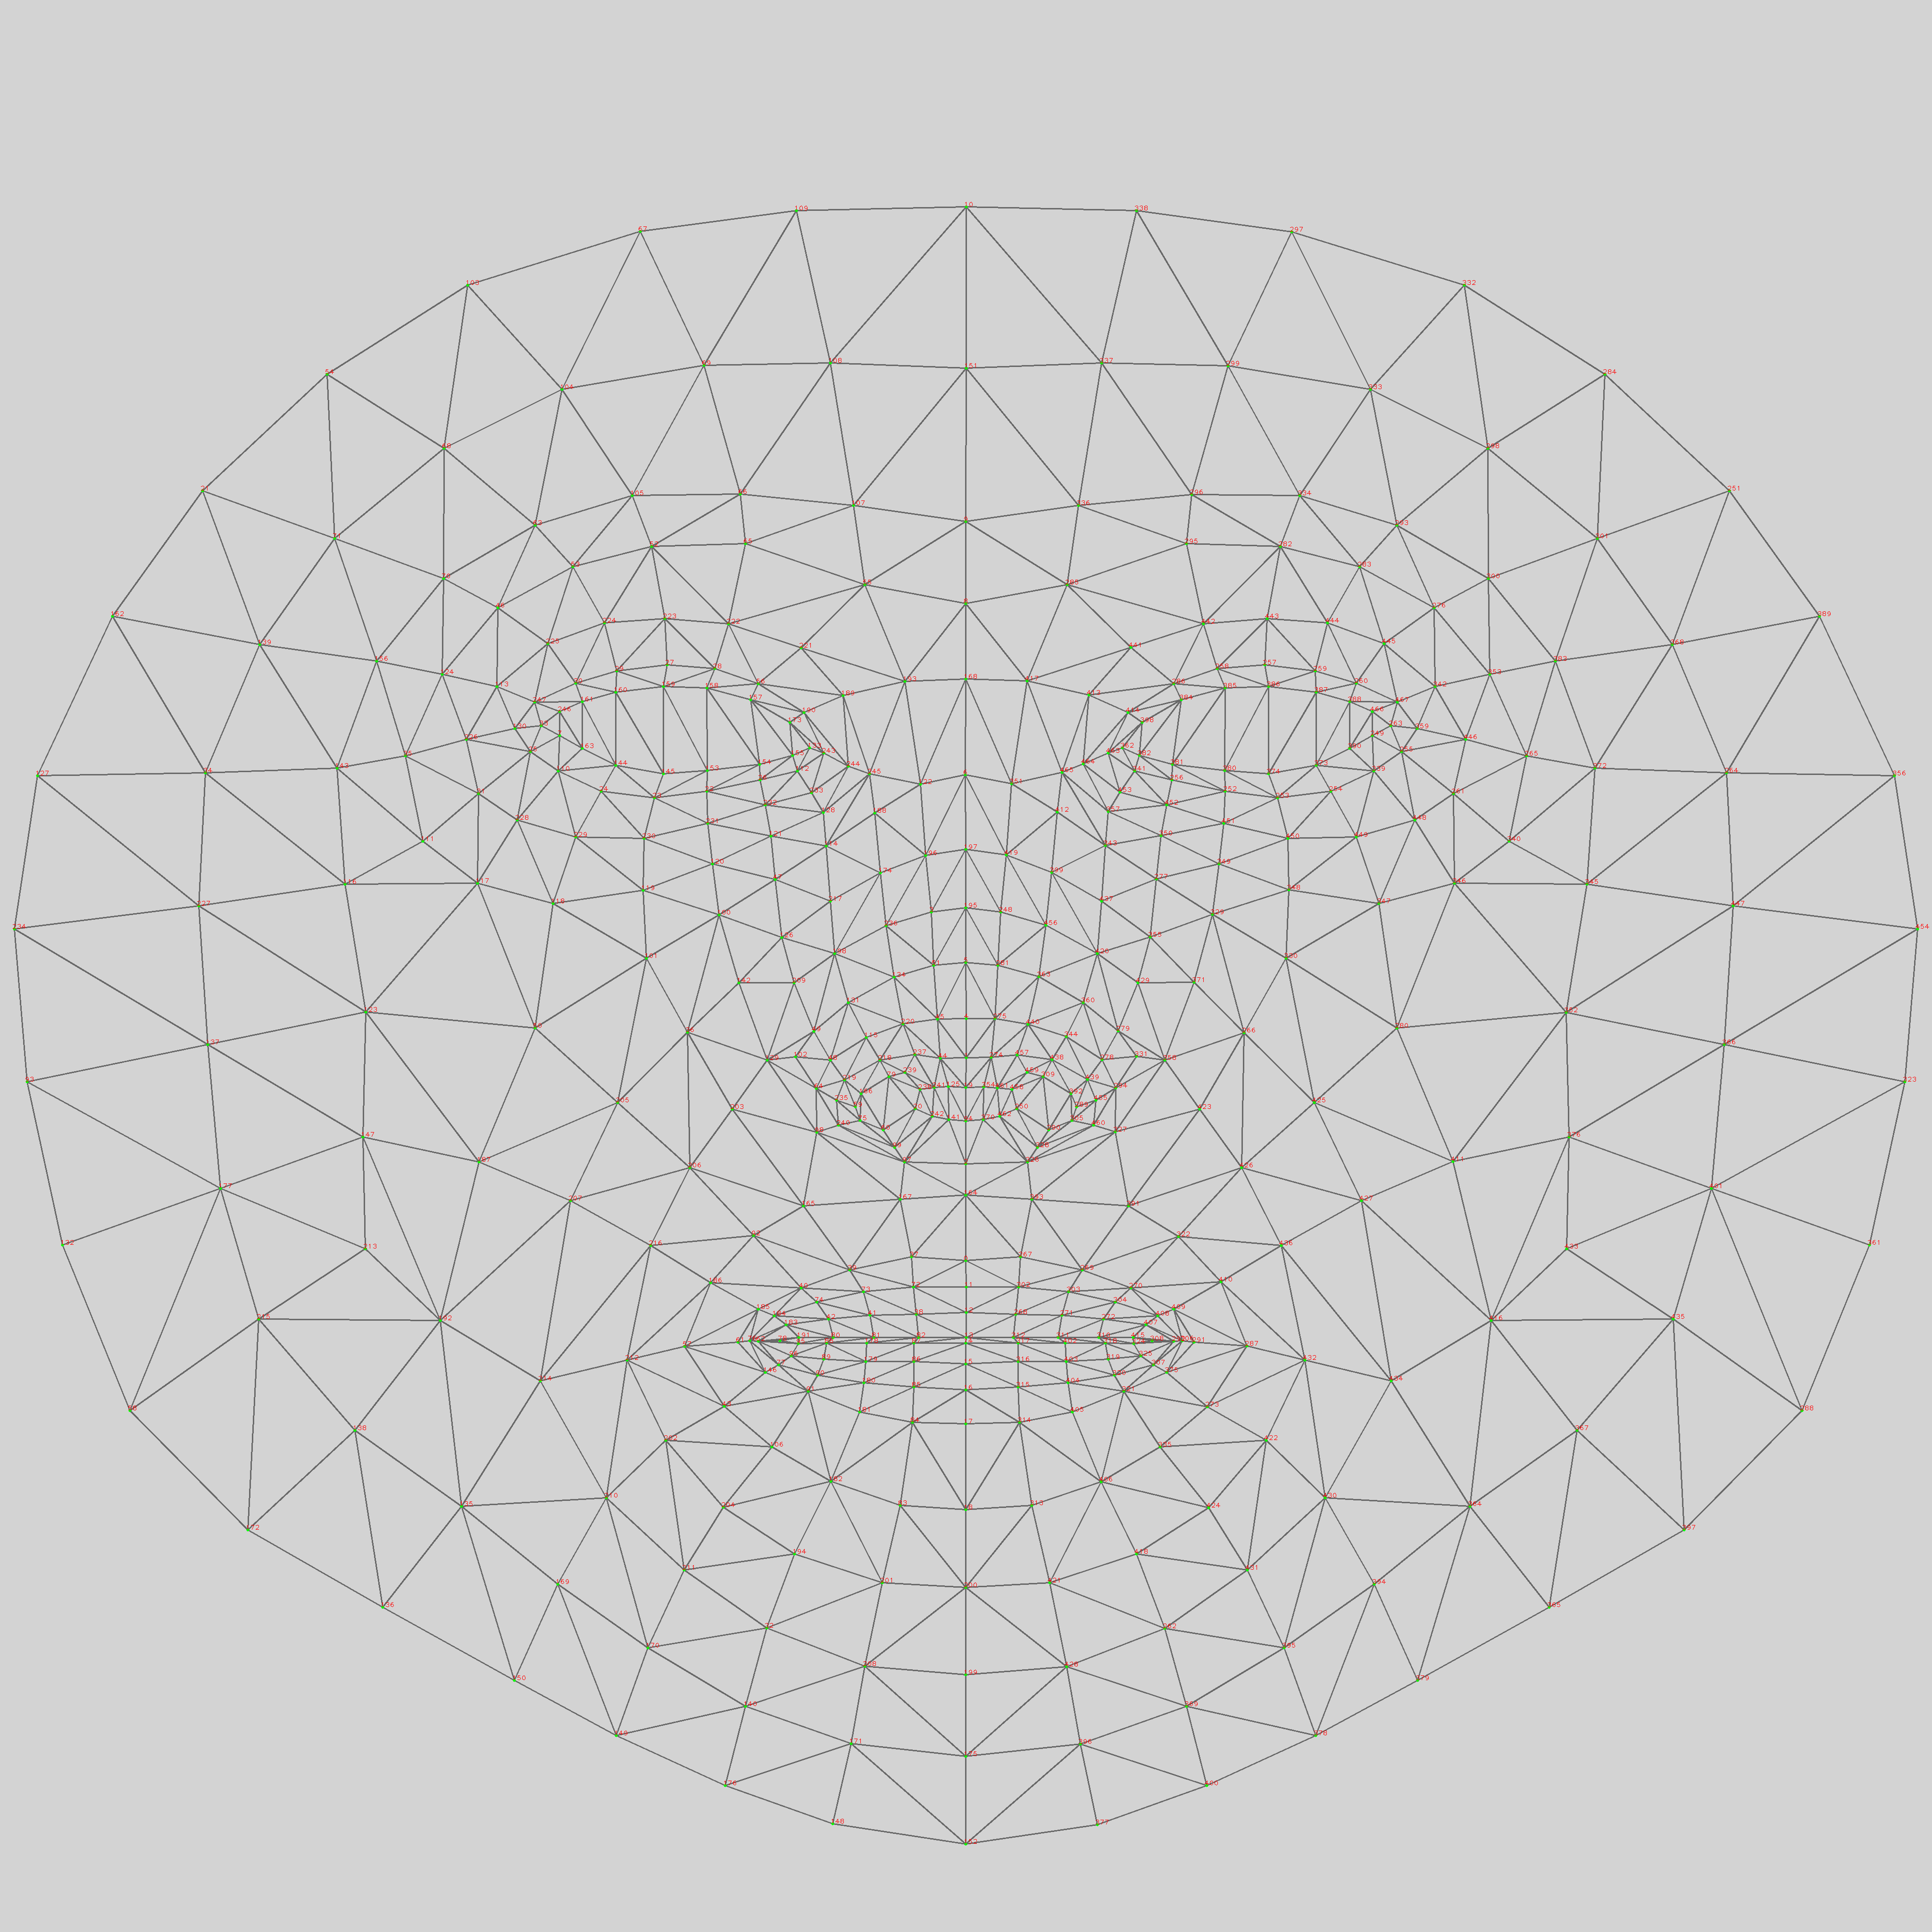

In [11]:
def extract_features(img, face_mesh, mat=None):
    # Define constants for landmark indices
    NOSE_LM_IDX = 1
    FOREHEAD_LM_IDX = 10
    LEFT_EYE_LM_IDX = 33
    MOUTH_LEFT_LM_IDX = 61
    CHIN_LM_IDX = 199
    RIGHT_EYE_LM_IDX = 263
    MOUTH_RIGHT_LM_IDX = 291

    # Process the image using the face mesh object
    result = face_mesh.process(img)

    # Extract features for each detected face
    face_features = []
    if result.multi_face_landmarks is not None:
        for face_landmarks in result.multi_face_landmarks:
            for idx, landmark in enumerate(face_landmarks.landmark):
                if idx in [NOSE_LM_IDX, FOREHEAD_LM_IDX, LEFT_EYE_LM_IDX, 
                           MOUTH_LEFT_LM_IDX, MOUTH_RIGHT_LM_IDX, CHIN_LM_IDX, RIGHT_EYE_LM_IDX]:
                    face_features.extend([landmark.x, landmark.y])
    else:
        # If no face is detected, set features to None
        face_features.extend([None] * 14)

    # Append pose angles if mat file is provided
    if mat:
        pose_angles = mat['Pose_Para'][0][:3]
        face_features.extend(pose_angles)

    return face_features

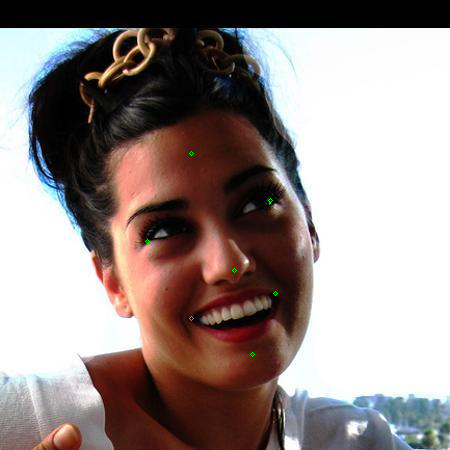

In [12]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
features = extract_features(img, face_mesh)
annot_img = img.copy()

for i in range(len(features)//2):
        cv2.circle(annot_img, center=[int(features[i*2]*img_w), int(features[i*2+1]*img_h)], radius=2, color=(0, 255, 0))

cv2_imshow(annot_img)


## Creating DataFrame

In [13]:
cols = []
for pos in ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']:
    for dim in ('x', 'y'):
        cols.append(pos+dim)
cols.extend(['pitch', 'yaw', 'roll'])

In [14]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
poses = []

for img_idx, img_path in enumerate(image_paths):
    img = cv2.imread(img_path)

    mat = scipy.io.loadmat(img_info_paths[img_idx])
    face_features = extract_features(img, face_mesh, mat)
    poses.append(face_features)
    if img_idx % 100 == 0:
        print('Extracted images: ', img_idx)

poses_df = pd.DataFrame(poses, columns=cols)

Extracted images:  0
Extracted images:  100
Extracted images:  200
Extracted images:  300
Extracted images:  400
Extracted images:  500
Extracted images:  600
Extracted images:  700
Extracted images:  800
Extracted images:  900
Extracted images:  1000
Extracted images:  1100
Extracted images:  1200
Extracted images:  1300
Extracted images:  1400
Extracted images:  1500
Extracted images:  1600
Extracted images:  1700
Extracted images:  1800
Extracted images:  1900


In [15]:
poses_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.491499,0.651907,0.521144,0.298103,0.353828,0.446450,0.414358,0.688906,0.488548,0.795088,0.673261,0.470436,0.578336,0.702029,-0.399231,0.018227,0.085676
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.470065,1.189533,0.300959
2,0.435542,0.613129,0.450925,0.406086,0.417164,0.516139,0.462587,0.670622,0.508088,0.737570,0.587741,0.510436,0.558758,0.671537,-0.184650,0.881137,-0.236852
3,0.475122,0.648519,0.413919,0.383364,0.356533,0.517100,0.464463,0.689012,0.554036,0.759729,0.603508,0.472810,0.603984,0.659333,-0.175379,0.299208,-0.373374
4,0.382822,0.624920,0.387799,0.402218,0.402052,0.510587,0.449415,0.694278,0.483491,0.760695,0.512404,0.502096,0.511552,0.695167,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.197102,-0.070430,0.105118
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.232617,-1.418751,0.175960
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.447955,1.431267,-1.509418
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.420465,-1.191176,0.451515


In [16]:
poses_df = poses_df.dropna(axis=0)

In [17]:
poses_df.shape

(1535, 17)

## Preprocessing
To make the system independent of the size of the images it was trained on or the face position in them, we have to perform some preprocessing:
1- Center the face features around the fixed point (nose), this makes the model work with faces that can take any position in the image, whether it was in the center of the image or the top right, etc..
2- Make the face features scale independent so they don't get affected by the distance between the face and the camera (whether you was close to the camera or not), this can be done by scaling the features by the distacne between 2 points on the face.

In [18]:
def normalize(poses_df):
    normalized_df = poses_df.copy()
    
    for dim in ['x', 'y']:
        # Centerning around the nose 
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = poses_df[feature] - poses_df['nose_'+dim]
        
        
        # Scaling
        diff = normalized_df['mouth_right_'+dim] - normalized_df['left_eye_'+dim]
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = normalized_df[feature] / diff
    
    return normalized_df

In [19]:
poses_df = normalize(poses_df)
poses_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.0,0.0,0.132045,-1.384326,-0.613210,-0.803889,-0.343601,0.144764,-0.013146,0.560222,0.809600,-0.710042,0.386790,0.196111,-0.399231,0.018227,0.085676
2,0.0,0.0,0.108639,-1.332336,-0.129795,-0.624139,0.191003,0.369971,0.512352,0.800784,1.074893,-0.660836,0.870205,0.375861,-0.184650,0.881137,-0.236852
3,0.0,0.0,-0.247336,-1.864222,-0.479242,-0.923966,-0.043077,0.284694,0.318908,0.781883,0.518835,-1.235355,0.520758,0.076034,-0.175379,0.299208,-0.373374
4,0.0,0.0,0.045452,-1.206531,0.175611,-0.619419,0.608155,0.375762,0.919346,0.735592,1.183386,-0.665422,1.175611,0.380581,-0.882169,1.198004,-1.033374
5,0.0,0.0,-0.219547,-1.585774,-0.611990,-0.567831,-0.194242,0.647600,0.170165,1.071458,0.472533,-0.922468,0.388010,0.432169,-0.026812,0.011965,-0.220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,0.0,0.0,0.142997,-1.537831,-0.011084,-0.651725,0.300751,0.377849,0.550763,0.877275,1.208415,-0.801267,0.988916,0.348275,-0.202474,1.198175,-0.352237
1989,0.0,0.0,-0.173672,-1.610357,-1.018724,-0.718234,-0.648367,0.356692,-0.280629,0.814382,0.266849,-0.803454,-0.018724,0.281766,-0.482186,-0.389773,0.056335
1990,0.0,0.0,-0.179621,-1.479250,-0.786384,-0.655488,-0.434267,0.381153,-0.029173,0.862005,0.397712,-0.765349,0.213616,0.344512,-0.173351,-0.060273,0.000774
1991,0.0,0.0,-0.123872,-1.479000,-0.896005,-0.687030,-0.534231,0.344623,-0.187538,0.782800,0.359508,-0.705292,0.103995,0.312970,-0.306358,-0.283822,0.038554


## Splitting The data

In [20]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(poses_df, test_size=0.2, random_state=42)


X_train = train_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_train = train_df[['pitch', 'yaw', 'roll']]

X_val = val_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_val = val_df[['pitch', 'yaw', 'roll']]
print(X_train.shape, y_train.shape)

(1228, 14) (1228, 3)



# Train a machine learning model
1.   Support Vector Regressor
2.   Desicion Tree Regressor
3.   Random Forest

1- SVR Training

In [21]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
from sklearn.metrics import mean_squared_error

param_grid = {
    'estimator__kernel': ['linear', 'poly', 'rbf'],
    'estimator__C': scipy.stats.expon(scale=5),
    'estimator__degree': np.arange(2, 6),
    'estimator__coef0': np.arange(0, 6),
    'estimator__gamma': scipy.stats.expon(scale=.1),
    'estimator__epsilon': scipy.stats.expon(scale=.1)
}

svr = SVR()
multi_out_svr = MultiOutputRegressor(svr)
random_search = RandomizedSearchCV(multi_out_svr, param_grid, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)
svr_model = random_search.best_estimator_
#Evaluate the model
print('best parameters: ', random_search.best_params_)
print('train_RMSE: ', np.sqrt(-random_search.best_score_))
print('validation_RMSE: ', np.sqrt(mean_squared_error(y_val, svr_model.predict(X_val))))

best parameters:  {'estimator__C': 2.3463404498842957, 'estimator__coef0': 4, 'estimator__degree': 4, 'estimator__epsilon': 0.13167456935454494, 'estimator__gamma': 0.09129425537759533, 'estimator__kernel': 'rbf'}
train_RMSE:  0.15793434184714786
validation_RMSE:  0.17074284756691116


2- Decision Tree Training

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'estimator__max_depth': np.arange(2, 10),
    'estimator__min_samples_split': np.logspace(1, 7, 7, base=2).astype(int),
    'estimator__min_samples_leaf': np.logspace(0, 6, 7, base=2).astype(int),
    'estimator__max_features': np.arange(4, 15),
    'estimator__ccp_alpha': scipy.stats.expon(scale=.1),
}

reg_tree = DecisionTreeRegressor(random_state=42)
multi_out_tree = MultiOutputRegressor(reg_tree)

random_search = RandomizedSearchCV(multi_out_tree, param_grid, scoring='neg_mean_squared_error', n_iter=40)
random_search.fit(X_train, y_train)
tree_model = random_search.best_estimator_
#Evaluate the model
print('best parameters: ', random_search.best_params_)
print('train_RMSE: ', np.sqrt(-random_search.best_score_))
print('validation_RMSE: ', np.sqrt(mean_squared_error(y_val, tree_model.predict(X_val))))

best parameters:  {'estimator__ccp_alpha': 0.008783150430789548, 'estimator__max_depth': 8, 'estimator__max_features': 14, 'estimator__min_samples_leaf': 16, 'estimator__min_samples_split': 32}
train_RMSE:  0.21500518979853891
validation_RMSE:  0.21562520856636314


3- Random Forest Regressor

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
from sklearn.metrics import mean_squared_error

param_grid = {
    'n_estimators': scipy.stats.randint(10, 500),
    'max_depth': [None] + list(range(1, 20)),
    'min_samples_split': scipy.stats.randint(2, 20),
    'min_samples_leaf': scipy.stats.randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_reg = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf_reg, param_grid, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)
rf_reg_model = random_search.best_estimator_
print('best parameters: ', random_search.best_params_)
print('train_RMSE: ', np.sqrt(-random_search.best_score_))
print('validation_RMSE: ', np.sqrt(mean_squared_error(y_val, rf_reg_model.predict(X_val))))


best parameters:  {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 16, 'n_estimators': 453}
train_RMSE:  0.16412809321650207
validation_RMSE:  0.1587790398715847


I will use the Random Forest Regressor model because it gave a better performance

### Test the project

Testing the Model on Training Images

Image shape:  (450, 450, 3)
targets:  [ 0.11543383  0.18698484 -0.19551753]


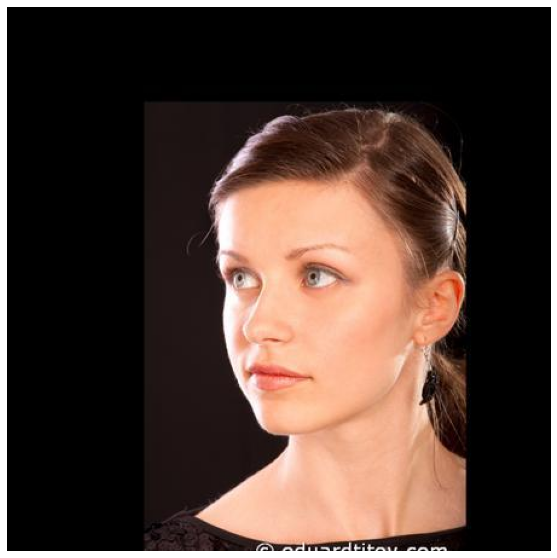

In [25]:
test_image = 18
images_paths = glob.glob('./AFLW2000/*.jpg')
img = cv2.imread(images_paths[test_image])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: ', img.shape)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img);

img_info_paths = glob.glob('./AFLW2000/*.mat')
mat = scipy.io.loadmat(img_info_paths[test_image])
print('targets: ', mat['Pose_Para'][0][:3].ravel()) 

In [26]:
cols = []
for pos in ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']:
    for dim in ('x', 'y'):
        cols.append(pos+dim)

face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
face_features = extract_features(img, face_mesh)
face_features_df = pd.DataFrame([face_features], columns=cols)
face_features_normalized = normalize(face_features_df)
pitch_pred, yaw_pred, roll_pred = rf_reg_model.predict(face_features_normalized).ravel()
print('predictions: ', pitch_pred, yaw_pred, roll_pred)

predictions:  -0.19519881507086714 0.6536950096403579 -0.14387145811561147


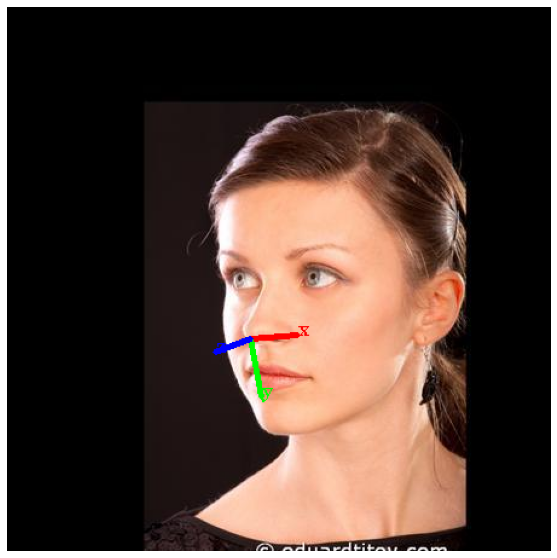

In [27]:
img_h, img_w, img_c = img.shape
nose_x = face_features_df['nose_x'].values * img_w
nose_y = face_features_df['nose_y'].values * img_h

new_img = draw_axes(img, pitch_pred, yaw_pred, roll_pred, nose_x, nose_y)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(new_img);

Testing the Model on Training Videos

In [32]:
from google.colab.patches import cv2_imshow

face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

cap = cv2.VideoCapture('/content/Studio_Project.mp4') 
fps = cap.get(cv2.CAP_PROP_FPS)
# Get the frame size (width, height) of the input video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # codec for the output video
out = cv2.VideoWriter('output.mp4', fourcc, fps, (frame_width, frame_height)) # output video path, codec, FPS, and frame size


while(cap.isOpened()):
    
    # Take each frame
    ret, img = cap.read()
    if ret:
        # img = cv2.flip(img, 0)
        img_h, img_w, img_c = img.shape
        text = ''
        

        face_features = extract_features(img, face_mesh)
        if face_features[0] == None :
          img = draw_axes(img)
          out.write(img)
          continue
        if len(face_features):
            face_features_df = pd.DataFrame([face_features], columns=cols)
            face_features_normalized = normalize(face_features_df)
            pitch_pred, yaw_pred, roll_pred = rf_reg_model.predict(face_features_normalized).ravel()
            nose_x = face_features_df['nose_x'].values * img_w
            nose_y = face_features_df['nose_y'].values * img_h
            img = draw_axes(img, pitch_pred, yaw_pred, roll_pred, nose_x, nose_y)
                        
            if pitch_pred > 0.3:
                text = 'Looking Up'
                if yaw_pred > 0.3:
                    text = 'Looking Up Left'
                elif yaw_pred < -0.3:
                    text = 'Looking Up Right'
            elif pitch_pred < -0.3:
                text = 'Looking Down'
                if yaw_pred > 0.3:
                    text = 'Looking Down Left'
                elif yaw_pred < -0.3:
                    text = 'Looking Down Right'
            elif yaw_pred > 0.3:
                text = 'Looking Left'
            elif yaw_pred < -0.3:
                text = 'Looking Right'
            else:
                text = 'Looking Forward'
                
        cv2.putText(img, text, (25, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        out.write(img) # write the frame to the output video
        # cv2_imshow(img)
        k = cv2.waitKey(1) & 0xFF
        if k == ord("q"):
            break
    else:
        break

# Release everything if job is finished
# cap.release()
out.release()
cv2.destroyAllWindows()
